In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [47]:
df=pd.read_csv("sample_data/TESLA.csv")
df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
1,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
3,2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500
4,2010-07-08,1.076000,1.168000,1.038000,1.164000,1.164000,115671000


In [48]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

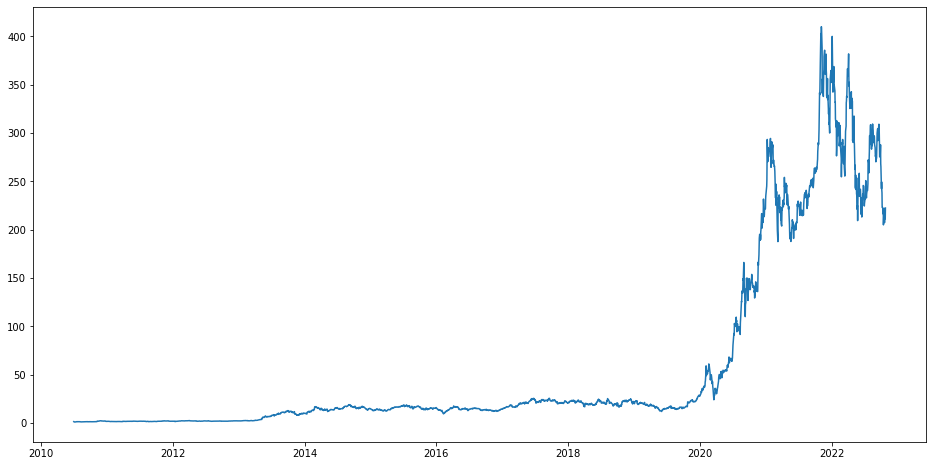

In [49]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [50]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [51]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

In [52]:
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [53]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)


In [54]:
final_dataset=new_dataset.values

In [55]:
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

In [56]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

In [68]:
x_train_data,y_train_data=[],[]
for i in range(20,len(train_data)):
    x_train_data.append(scaled_data[i-20:i,0])
    y_train_data.append(scaled_data[i,0])


In [69]:
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [70]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [71]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

967/967 - 12s - loss: 1.2297e-05 - 12s/epoch - 12ms/step


In [80]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-20:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [81]:
from keras.models import Model
X_test=[]
for i in range(20,inputs_data.shape[0]):
    X_test.append(inputs_data[i-20:i,0])
X_test=np.array(X_test)
print(X_test)


[[0.04875647 0.05137151 0.05201549 ... 0.05505115 0.05407622 0.05256002]
 [0.05137151 0.05201549 0.05120848 ... 0.05407622 0.05256002 0.05054494]
 [0.05201549 0.05120848 0.05241818 ... 0.05256002 0.05054494 0.0538333 ]
 ...
 [0.67073973 0.67240271 0.68934991 ... 0.53589566 0.54041979 0.50432443]
 [0.67240271 0.68934991 0.70125942 ... 0.54041979 0.50432443 0.52183412]
 [0.68934991 0.70125942 0.65332788 ... 0.50432443 0.52183412 0.51403301]]


In [82]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))


In [83]:
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

lstm_model.save("saved_lstm_model.h5")

31/31 [==============================] - 0s 6ms/step


In [84]:
lstm_model.save("saved_lstm_model.h5")

<ipython-input-85-240245a82455>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


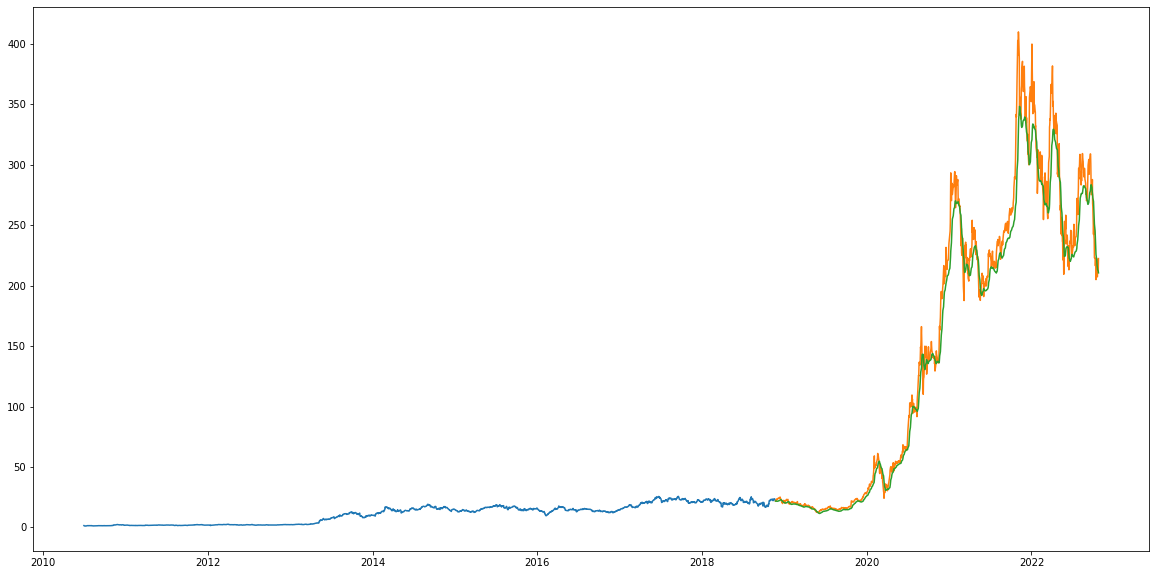

In [85]:
train_data=new_dataset[:2115]
valid_data=new_dataset[2115:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

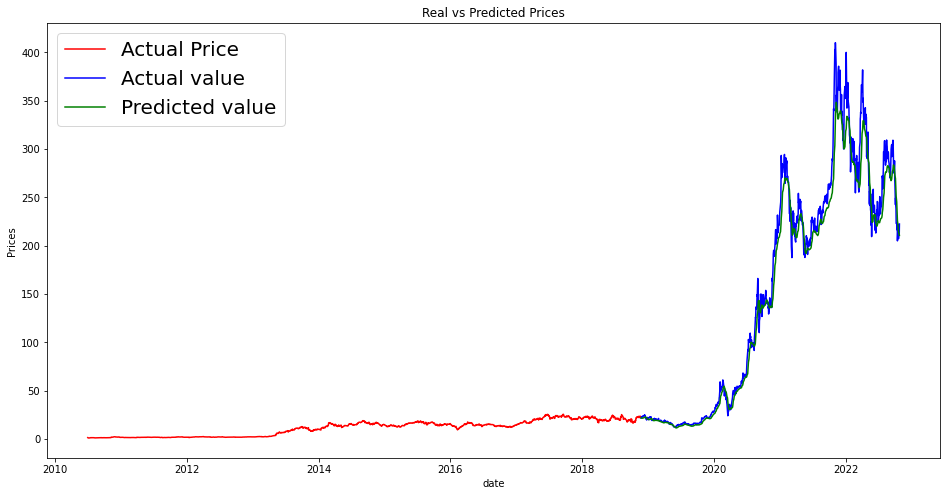

In [86]:
plt.figure(figsize= (16,8))
plt.plot(train_data['Close'], 'red', label= 'Actual Price')
plt.plot(valid_data[['Close']], 'blue', label= 'Actual value')
plt.plot(valid_data[["Predictions"]], 'green', label= 'Predicted value')
plt.xlabel('date')
plt.ylabel('Prices')
plt.title('Real vs Predicted Prices')
plt.legend(loc='best', fontsize=20)